In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from var import VaR

/Users/yhc/Desktop/MLVaR/MLVaR/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%load_ext autoreload
%autoreload 2
# Load data

In [3]:
# Load data
file_name = 'GBPUSD1440.csv'
sample = pd.read_csv(file_name, index_col=0, sep='\t',
                       names=['open', 'high', 'low', 'close', 'volume'])
sample.index  = pd.to_datetime(sample.index)
sample.head()


,open,high,low,close,volume
2008-09-12,1.76880,1.79590,1.76330,1.7940,155157
2008-09-14,1.80507,1.80731,1.79555,1.7981,14797
2008-09-15,1.79825,1.81290,1.77640,1.7943,622869
2008-09-16,1.79435,1.79945,1.77330,1.7860,632307
2008-09-17,1.78600,1.82440,1.77835,1.8138,573605


In [4]:
# Initialize VaR
sample_var = VaR(sample, price_col='close', alpha=0.05, window=125, period=5)

# Basic features calculated automatically
sample_var.data.head()

,open,high,low,close,volume,return,vol,loss,exp_mean,exp_vol
2009-02-05,1.44535,1.47030,1.43640,1.46260,230799,0.011864,0.012936,0.018911,-0.003782,0.012998
2009-02-06,1.46260,1.48445,1.45880,1.47830,210858,0.010677,0.012978,0.034198,-0.006840,0.013004
2009-02-08,1.47850,1.48630,1.47675,1.48155,4559,0.002196,0.012983,0.031854,-0.006371,0.013012
2009-02-09,1.48140,1.49855,1.47015,1.48515,255888,0.002427,0.012984,0.042503,-0.008501,0.013007
2009-02-10,1.48510,1.48930,1.44540,1.45550,292649,-0.020166,0.013001,0.018165,-0.003633,0.013001


In [5]:
# Calculate Historical VaR
sample_var.calculate_var(col_name='HistVaR', type='historical')

# Calculate Parametric VaR
sample_var.calculate_var(col_name='ParamVaR', type='parametric')

# Calculate Monte Carlo VaR
sample_var.calculate_monte_carlo_var(col_name='MonteCarloVaR', num_simulations=10000)

HistVaR Successfully Calculated!
ParamVaR Successfully Calculated!
MonteCarloVaR Successfully Calculated!


In [6]:
# Prepare features and targets for LSTM
sample_var.calculate_moving_average(input_col='return', output_col='MA_return_5', window=5)
sample_var.calculate_moving_average(input_col='return', output_col='MA_return_10', window=10)
sample_var.calculate_moving_average(input_col='return', output_col='MA_return_20', window=20)
sample_var.calculate_moving_average(input_col='return', output_col='MA_return_60', window=60)

sample_var.calculate_moving_average(input_col='vol', output_col='MA_vol_5', window=5)
sample_var.calculate_moving_average(input_col='vol', output_col='MA_vol_10', window=10)
sample_var.calculate_moving_average(input_col='vol', output_col='MA_vol_20', window=20)
sample_var.calculate_moving_average(input_col='vol', output_col='MA_vol_60', window=60)

MA_return_5 Successfully Calculated!
MA_return_10 Successfully Calculated!
MA_return_20 Successfully Calculated!
MA_return_60 Successfully Calculated!
MA_vol_5 Successfully Calculated!
MA_vol_10 Successfully Calculated!
MA_vol_20 Successfully Calculated!
MA_vol_60 Successfully Calculated!


In [7]:
# Create train data for return series
sample_var.create_train_data(type='return', seq_length=60,
                             feature_cols=['return','vol', 'MA_return_5', 'MA_return_10', 'MA_return_20', 'MA_return_60',
                                           'MA_vol_5', 'MA_vol_10', 'MA_vol_20', 'MA_vol_60'],
                             target_cols=['exp_mean'])


return Train Data Successfully Created!
return Backtest Data Successfully Created!


In [8]:
# Create train data for vol series
sample_var.create_train_data(type='vol', seq_length=60,
                             feature_cols=['vol', 'MA_vol_5', 'MA_vol_10', 'MA_vol_20', 'MA_vol_60'],
                             target_cols=['exp_vol'])

vol Train Data Successfully Created!
vol Backtest Data Successfully Created!


In [9]:
# Create LSTM model for return series
sample_var.create_LSTM_model(type='return', lstm_units=32, output_units=1, learning_rate=0.0000001)

return LSTM Model Successfully Created!


In [ ]:
# Define callbacks for return model and Train It
ret_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='r2_score',
                                                  patience=20, mode='max', restore_best_weights=True)
callbacks = [ret_early_stopping]

# Train return model
# Note: Training process and record are omitted here for brevity
sample_var.train_LSTM_model(type='return', epochs=100, callbacks=callbacks)


In [ ]:
# Create LSTM model for vol series
sample_var.create_LSTM_model(type='vol', lstm_units=32, output_units=1, learning_rate=0.000005)

# Define callbacks for vol model and Train It
vol_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_r2_score',
                                                  patience=10, mode='max', restore_best_weights=True)
callbacks = [vol_early_stopping]

# Train return model
# Note: Training process and record are omitted here for brevity
sample_var.train_LSTM_model(type='vol', epochs=50, validation_ratio=0.2, callbacks=callbacks)

In [ ]:
# Calculate LSTM VaR
# Note: Training process and record are omitted here for brevity
sample_var.LSTM_predict(num_simulations=10000,hist_ret_col='MA_return_60')

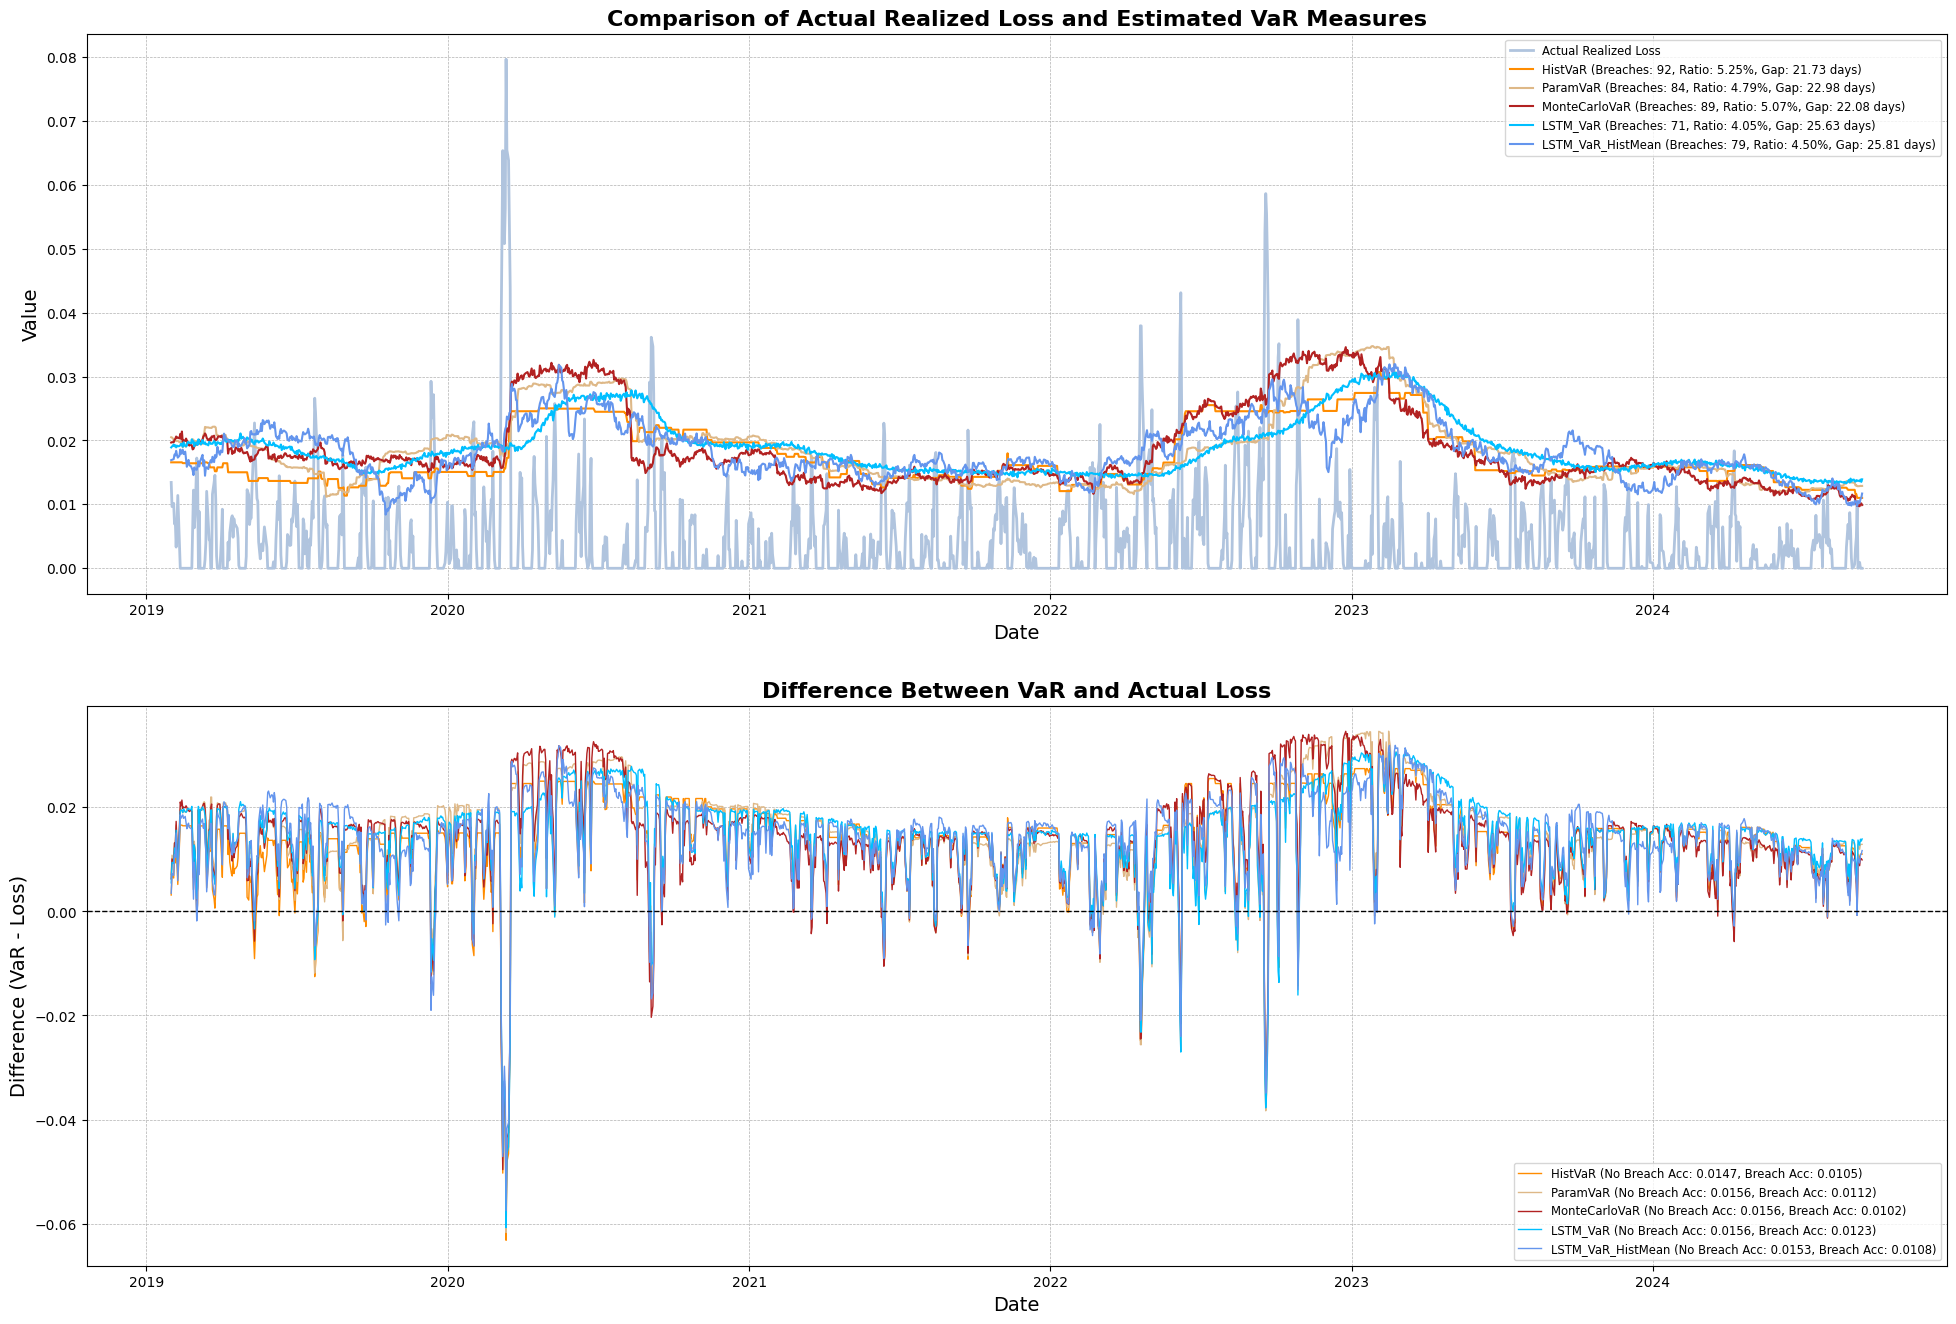

In [20]:
sample_var.plot_var()